In [1]:
import os
import time
import numpy as np
import subprocess
import h5py
import matplotlib.pyplot as plt
import sys
import random
import json

import tensorflow as tf
from tensorflow import keras

2022-08-09 12:08:15.086219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 12:08:15.086314: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
fig_size = (15, 15)
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)

batch_size = 100
test_batches = 1
n_topk = 2
max_seq_len = 25

base_path = "../log_08_08_22_2/"
predict_rnn = False

#base_path = "log_08_08_22_rnn/"
#predict_rnn = True # set to True for RNN model

# log_08_08_22_2 (finish time: 40,000 steps in 158683.60082054138 seconds)
# log_08_08_22_rnn (finish time: 40,000 steps in 173480.83078551292 seconds)

#"log_03_08_22_1/" Balanced data with really selection of low freq tools - random choice
# RNN: log_01_08_22_3_rnn
# Transformer: log_01_08_22_0

model_number = 40000
model_path = base_path + "saved_model/" + str(model_number) + "/tf_model/"


def remove_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)


def read_file(file_path):
    """
    Read a file
    """
    with open(file_path, "r") as json_file:
        file_content = json.loads(json_file.read())
    return file_content


def write_file(file_path, content):
    """
    Write a file
    """
    remove_file(file_path)
    with open(file_path, "w") as json_file:
        json_file.write(json.dumps(content))


r_dict = read_file(base_path + "data/rev_dict.txt")
f_dict = read_file(base_path + "data/f_dict.txt")

path_test_data = base_path + "saved_data/test.h5"

file_obj = h5py.File(path_test_data, 'r')

test_input = np.array(file_obj["input"])
test_target = np.array(file_obj["target"])

class_weights = read_file(base_path + "data/class_weights.txt")
compatible_tools = read_file(base_path + "data/compatible_tools.txt")

#tool_freq = utils.read_file(base_path + "data/freq_dict_names.txt")
published_connections = read_file(base_path + "data/published_connections.txt")

c_weights = list(class_weights.values())

c_weights = tf.convert_to_tensor(c_weights, dtype=tf.float32)

te_lowest_t_ids = read_file(base_path + "data/te_lowest_t_ids.txt")
lowest_t_ids = [int(item) for item in te_lowest_t_ids.split(",")]
tool_tr_freq = read_file(base_path + "data/all_sel_tool_ids.txt")

all_sel_tool_ids = read_file(base_path + "data/all_sel_tool_ids.txt").split(",")

2022-08-09 12:08:24.150485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-09 12:08:24.150944: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-09 12:08:24.151232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anupkumar-HP-ProBook-450-G5): /proc/driver/nvidia/version does not exist
2022-08-09 12:08:24.154735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
test_target

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
def generated_attention(attention_weights, i_names, f_dict, r_dict):

    #print(attention_weights.shape)
    attention_heads = tf.squeeze(attention_weights, 0)
    n_heads = attention_heads.shape[1]
    i_names = i_names.split(",")
    in_tokens = i_names
    out_tokens = i_names
    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
      ax = fig.add_subplot(2, n_heads, h+1)
      plot_attention_head(in_tokens, out_tokens, head)
      ax.set_xlabel(f'Head {h+1}')
    plt.tight_layout()
    plt.show()

In [5]:
def plot_attention_head(in_tokens, out_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  #translated_tokens = translated_tokens[1:]
  #print(attention)
  ax = plt.gca()
  ax.matshow(attention[:len(in_tokens), :len(out_tokens)])
  #ax.matshow(attention[:len(in_tokens), :])

  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(out_tokens)))

  ax.set_xticklabels(in_tokens, rotation=90)
  ax.set_yticklabels(out_tokens)


def visualize_loss_acc():
    epo_tr_batch_loss = read_file(base_path + "data/epo_tr_batch_loss.txt").split(",")

    #print(len(epo_tr_batch_loss))
    epo_tr_batch_loss = [np.round(float(item), 4) for item in epo_tr_batch_loss]

    epo_tr_batch_acc = read_file(base_path + "data/epo_tr_batch_acc.txt").split(",")
    epo_tr_batch_acc = [np.round(float(item), 4) for item in epo_tr_batch_acc]

    epo_te_batch_loss = read_file(base_path + "data/epo_te_batch_loss.txt").split(",")
    epo_te_batch_loss = [np.round(float(item), 4) for item in epo_te_batch_loss]

    epo_te_batch_acc = read_file(base_path + "data/epo_te_precision.txt").split(",")
    epo_te_batch_acc = [np.round(float(item), 4) for item in epo_te_batch_acc]

    plot_loss_acc(epo_tr_batch_loss, epo_tr_batch_acc, "training")
    plot_loss_acc(epo_te_batch_loss, epo_te_batch_acc, "test")

    epo_te_low_batch_acc = read_file(base_path + "data/epo_low_te_precision.txt").split(",")
    epo_te_low_batch_acc = [np.round(float(item), 4) for item in epo_te_low_batch_acc]

    plot_low_te_prec(epo_te_low_batch_acc, "Low test")

In [6]:
def load_model():
    return tf.saved_model.load(model_path)
tf_loaded_model = load_model()

In [7]:
def sample_balanced_tr_y(x_seqs, y_labels, ulabels_tr_y_dict):
    batch_y_tools = list(ulabels_tr_y_dict.keys())
    random.shuffle(batch_y_tools)
    label_tools = list()
    rand_batch_indices = list()

    for l_tool in batch_y_tools:
        seq_indices = ulabels_tr_y_dict[l_tool]
        random.shuffle(seq_indices)
        
        if seq_indices[0] not in rand_batch_indices:
            rand_batch_indices.append(seq_indices[0])
            label_tools.append(l_tool)
        if len(rand_batch_indices) == batch_size:
            break
    
    x_batch_train = x_seqs[rand_batch_indices]
    y_batch_train = y_labels[rand_batch_indices]

    unrolled_x = tf.convert_to_tensor(x_batch_train, dtype=tf.int64)
    unrolled_y = tf.convert_to_tensor(y_batch_train, dtype=tf.int64)
    return unrolled_x, unrolled_y, label_tools, rand_batch_indices

In [8]:
def predict_custom_seq():

    n_topk_ind = 20
    t_ip = np.zeros((25))
    t_ip[0] = int(f_dict["snpEff_build_gb"])
    t_ip[1] = int(f_dict["bwa_mem"])
    t_ip[2] = int(f_dict["samtools_view"])

    last_tool_name = "samtools_view"
    
    t_ip = tf.convert_to_tensor(t_ip, dtype=tf.int64)
    if predict_rnn is True:
        prediction = tf_loaded_model([t_ip], training=False)
    else:
        prediction, att_weights = tf_loaded_model([t_ip], training=False)
    prediction_cwts = tf.math.multiply(c_weights, prediction)

    top_k = tf.math.top_k(prediction, k=n_topk_ind, sorted=True)
    top_k_wts = tf.math.top_k(prediction_cwts, k=n_topk_ind, sorted=True)

    t_ip = t_ip.numpy()
    label_pos = np.where(t_ip > 0)[0]

    i_names = ",".join([r_dict[str(item)] for item in t_ip[label_pos]  if item not in [0, "0"]])

    pred_tools = [r_dict[str(item)] for item in top_k.indices.numpy()[0]  if item not in [0, "0"]]
    pred_tools_wts = [r_dict[str(item)] for item in top_k_wts.indices.numpy()[0]  if item not in [0, "0"]]

    c_tools = [r_dict[str(item)] for item in compatible_tools[str(f_dict[last_tool_name])]]

    pred_intersection = list(set(pred_tools).intersection(set(c_tools)))
    prd_te_prec = len(pred_intersection) / float(n_topk_ind)

    print("Tool sequence: {}".format([r_dict[str(item)] for item in t_ip[label_pos]]))
    print()
    print("Compatible true tools: {}, size: {}".format(c_tools, len(c_tools)))
    print()
    print("Predicted top {} tools: {}".format(n_topk_ind, pred_tools))
    print()
    print("Predicted precision: {}".format(prd_te_prec))
    print()
    print("Correctly predicted tools: {}".format(pred_intersection))
    print()
    print("Predicted top {} tools with weights: {}".format(n_topk_ind, pred_tools_wts))
    print()
    if predict_rnn is False:
        generated_attention(att_weights, i_names, f_dict, r_dict)

In [9]:
def predict_low_freq_seq():
    
    
    low_te_data = test_input[lowest_t_ids]
    low_te_labels = test_target[lowest_t_ids]
    #print("Test lowest ids", low_te_data.shape, low_te_labels.shape)
    #low_te_pred_batch, low_att_weights = tf_loaded_model([low_te_data], training=False)
    low_topk = 5
    low_te_precision = list()
    for i, (low_inp, low_tar) in enumerate(zip(low_te_data, low_te_labels)):
        if predict_rnn is True:
            low_prediction = tf_loaded_model([low_inp], training=False)
        else:
            low_prediction, att_weights = tf_loaded_model([low_inp], training=False)
        #print(low_prediction.shape)
        
        low_label_pos = np.where(low_tar > 0)[0]
        low_topk = len(low_label_pos)
        low_topk_pred = tf.math.top_k(low_prediction, k=low_topk, sorted=True)
        low_topk_pred = low_topk_pred.indices.numpy()[0]
        
        low_label_pos_tools = [r_dict[str(item)] for item in low_label_pos if item not in [0, "0"]]
        low_pred_label_pos_tools = [r_dict[str(item)] for item in low_topk_pred if item not in [0, "0"]]

        low_intersection = list(set(low_label_pos_tools).intersection(set(low_pred_label_pos_tools)))
        low_pred_precision = float(len(low_intersection)) / len(low_label_pos)
        low_te_precision.append(low_pred_precision)
        
        #low_inp = low_inp.numpy()
        low_inp_pos = np.where(low_inp > 0)[0]

        print("Low: test tool sequence: {}".format([r_dict[str(int(item))] for item in low_inp[low_inp_pos]]))
        print()
        print("Low: True labels: {}".format(low_label_pos_tools))
        print()
        print("Low: Predicted labels: {}, Precision: {}".format(low_pred_label_pos_tools, low_pred_precision))
        print("-----------------")
        print()
    
    if len(lowest_t_ids) > 0:
        print("Low test prediction precision: {}".format(np.mean(low_te_precision)))


In [10]:
def verify_tool_in_tr(r_dict):
    

    freq_dict = dict()
    freq_dict_names = dict()

    for tool_id in all_sel_tool_ids:
        if tool_id not in freq_dict:
            freq_dict[tool_id] = 0

        if tool_id not in freq_dict_names:
            freq_dict_names[r_dict[str(int(tool_id))]] = 0

        freq_dict[tool_id] += 1
        freq_dict_names[r_dict[str(int(tool_id))]] += 1

    s_freq = dict(sorted(freq_dict.items(), key=lambda kv: kv[1], reverse=True))
    s_freq_names = dict(sorted(freq_dict_names.items(), key=lambda kv: kv[1], reverse=True))


    write_file(base_path + "data/s_freq_names.txt", s_freq_names)
    write_file(base_path + "data/s_freq.txt", s_freq)

    return s_freq

In [11]:
def get_u_tr_labels(y_tr):
    labels = list()
    labels_pos_dict = dict()
    for i, item in enumerate(y_tr):
        label_pos = np.where(item > 0)[0]
        labels.extend(label_pos)
        for label in label_pos:
            if label not in labels_pos_dict:
                labels_pos_dict[label] = list()
            labels_pos_dict[label].append(i)

    u_labels = list(set(labels))
    
    for item in labels_pos_dict:
        labels_pos_dict[item] = list(set(labels_pos_dict[item]))
    return u_labels, labels_pos_dict

In [12]:
def predict_seq():

    #visualize_loss_acc()

    
    #sys.exit()

    #verify_training_sampling(tool_tr_freq, r_dict)
    
    #r_dict = read_file(base_path + "data/rev_dict.txt")
    #f_dict = read_file(base_path + "data/f_dict.txt")
    
    all_tr_label_tools = verify_tool_in_tr(r_dict)

    all_tr_label_tools_ids = list(all_tr_label_tools.keys())
    all_tr_label_tools_ids = [int(t) for t in all_tr_label_tools_ids]
    
    
    print(test_input.shape, test_target.shape)

    
    u_te_y_labels, u_te_y_labels_dict = get_u_tr_labels(test_target)

    precision = list()
    pub_prec_list = list()
    error_label_tools = list()

    for j in range(test_batches):
        #te_x_batch, y_train_batch = sample_balanced(test_input, test_target, ulabels_te_dict)
        te_x_batch, y_train_batch, selected_label_tools, bat_ind = sample_balanced_tr_y(test_input, test_target, u_te_y_labels_dict)
        #print(j * batch_size, j * batch_size + batch_size)
        #te_x_batch = test_input[j * batch_size : j * batch_size + batch_size, :]
        #y_train_batch = test_target[j * batch_size : j * batch_size + batch_size, :]

        for i, (inp, tar) in enumerate(zip(te_x_batch, y_train_batch)):

            t_ip = inp
            if len(np.where(inp > 0)[0]) < max_seq_len:
                real_prediction = np.where(tar > 0)[0]
                target_pos = list(set(all_tr_label_tools_ids).intersection(set(real_prediction)))
                #print("Real predicted tools: {}, Actual trained labels: {}".format(real_prediction, target_pos))
                #print()
                t_ip = tf.convert_to_tensor(t_ip, dtype=tf.int64)
                if predict_rnn is True:
                    prediction = tf_loaded_model([t_ip], training=False)
                else:
                    prediction, att_weights = tf_loaded_model([t_ip], training=False)
                prediction_wts = tf.math.multiply(c_weights, prediction)

                n_topk = len(target_pos)
                top_k = tf.math.top_k(prediction, k=n_topk, sorted=True)
                top_k_wts = tf.math.top_k(prediction_wts, k=n_topk, sorted=True)

                t_ip = t_ip.numpy()
                label_pos = np.where(t_ip > 0)[0]

                i_names = ",".join([r_dict[str(item)] for item in t_ip[label_pos]  if item not in [0, "0"]])
                t_names = ",".join([r_dict[str(int(item))] for item in target_pos  if item not in [0, "0"]])

                last_i_tool = [r_dict[str(item)] for item in t_ip[label_pos]][-1]

                true_tools = [r_dict[str(int(item))] for item in target_pos]

                #print("Selected tool in true tools: {}".format(s_label_tool in true_tools))

                pred_tools = [r_dict[str(item)] for item in top_k.indices.numpy()[0]  if item not in [0, "0"]]
                pred_tools_wts = [r_dict[str(item)] for item in top_k_wts.indices.numpy()[0]  if item not in [0, "0"]]

                intersection = list(set(true_tools).intersection(set(pred_tools)))

                pub_prec = 0.0
                pub_prec_wt = 0.0

                if last_i_tool in published_connections:
                    true_pub_conn = published_connections[last_i_tool]
                    #print("Test batch {}, True published tools: {}".format(j+1, true_pub_conn)) 
                    #print()
                    if len(pred_tools) > 0:
                        intersection_pub = list(set(true_pub_conn).intersection(set(pred_tools)))
                        intersection_pub_wt = list(set(true_pub_conn).intersection(set(pred_tools_wts)))
                        pub_prec = float(len(intersection_pub)) / len(pred_tools)
                        pub_prec_list.append(pub_prec)
                        pub_prec_wt = float(len(intersection_pub_wt)) / len(pred_tools)
                    else:
                        pub_prec = False
                        pub_prec_wt = False

                if len(pred_tools) > 0:
                    pred_precision = float(len(intersection)) / len(pred_tools)
                    precision.append(pred_precision)

                if pred_precision < 2.0:
            
                    print("Test batch {}, Tool sequence: {}".format(j+1, [r_dict[str(item)] for item in t_ip[label_pos]]))
                    print()
                    print("Test batch {}, True tools: {}".format(j+1, true_tools))
                    print()
                    print("Test batch {}, Predicted top {} tools: {}".format(j+1, n_topk, pred_tools))
                    print()
                    print("Test batch {}, Predicted top {} tools with weights: {}".format(j+1, n_topk, pred_tools_wts))
                    print()
                    print("Test batch {}, Precision: {}".format(j+1, pred_precision)) 
                    print()
                    print("Test batch {}, Published precision: {}".format(j+1, pub_prec))
                    print()
                    print("Test batch {}, Published precision with weights: {}".format(j+1, pub_prec_wt))
                    #error_label_tools.append(select_tools[i])
                    print("=========================")
                print("--------------------------")
                #generated_attention(att_weights, i_names, f_dict, r_dict)
        
                print("Batch {} prediction finished ...".format(j+1))

    if test_batches > 0:
        print("Precision@{}: {}".format(n_topk, np.mean(precision)))
        print("Published Precision@{}: {}".format(n_topk, np.mean(pub_prec_list)))

In [13]:
predict_seq()

(103152, 25) (103152, 2198)
Test batch 1, Tool sequence: ['trim_galore', 'deeptools_bam_coverage', 'deeptools_compute_matrix', 'deeptools_plot_heatmap', 'Remove beginning1', 'bedtools_subtractbed', 'tp_sort_header_tool', 'tp_head_tool', 'Extract genomic DNA 1', 'macs2_callpeak', 'bowtie2', 'macs2_callpeak', 'samtools_rmdup', 'macs2_callpeak', 'diffbind', 'chipseeker', 'Cut1']

Test batch 1, True tools: ['bg_column_arrange_by_header', 'cshl_word_list_grep', 'taxonomy_krona_chart', 'tp_easyjoin_tool', 'tp_split_on_column', 'get_flanks1', 'join_files_on_column_fuzzy', 'regexColumn1', 'collection_column_join', 'plotly_ml_performance_plots', 'bg_uniq', 'venn_list', 'scanpy_read_10x', 'tp_find_and_replace', 'bedtools_slopbed', 'Paste1', 'Show beginning1', 'ggplot_histogram', 'krona-text', 'stacks_denovomap', 'XY_Plot_1', 'random_lines1', 'unipept', 'query_tabular', 'ChangeCase', 'tp_tail_tool', 'collapse_dataset', 'annotatemyids', 'join1', 'goseq', 'heinz_scoring', 'tp_uniq_tool', 'export2gr

In [14]:
predict_low_freq_seq()

Low: test tool sequence: ['rbc_splitfasta', 'hhsearch', 'collection_element_identifiers', 'ffindex_dbkit_create', 'ffindex_dbkit_merge']

Low: True labels: ['spring_model_all']

Low: Predicted labels: ['spring_model_all'], Precision: 1.0
-----------------

Low: test tool sequence: ['filtlong', 'flye', 'racon', 'maxbin2', 'prokka', 'roary']

Low: True labels: ['taxonomy_krona_chart', 'barchart_gnuplot', 'CONVERTER_fasta_to_fai', 'iqtree', 'fasttree', 'raxml', 'gubbins', 'gd_raxml', 'graphlan']

Low: Predicted labels: ['graphlan', 'raxml', 'barchart_gnuplot', 'CONVERTER_fasta_to_fai', 'fasttree', 'iqtree', 'taxonomy_krona_chart', 'gubbins', 'gd_raxml'], Precision: 1.0
-----------------

Low: test tool sequence: ['fastq_groomer', '__ZIP_COLLECTION__']

Low: True labels: ['__FILTER_EMPTY_DATASETS__', '__RELABEL_FROM_FILE__', 'hisat2', 'snippy_core', 'fastq_groomer', 'OMSSAAdapter', 'bwa_mem', 'trimmomatic', 'fastqc', 'salmon']

Low: Predicted labels: ['fastq_groomer', 'fastqc', 'bwa_mem', 

Tool sequence: ['snpEff_build_gb', 'bwa_mem', 'samtools_view']

Compatible true tools: ['collapse_dataset', 'samtools_fastx', '__EXTRACT_DATASET__', 'lofreq_viterbi', 'lofreq_alnqual', 'samtools_stats', 'samtools_merge', 'macs2_callpeak', 'samtools_sort', 'bedtools_intersectbed', 'ivar_trim', 'picard_MarkDuplicates', 'deeptools_bam_coverage', 'lofreq_indelqual', 'racon', 'Cut1', 'bedtools_bamtobed', 'Grouping1', 'freebayes', 'bamtools', 'deeptools_plot_fingerprint', 'tp_replace_in_line', 'samtools_rmdup', 'qualimap_bamqc', 'seq_filter_by_mapping', '__FILTER_FROM_FILE__', 'picard_SamToFastq', 'stringtie', 'trinity', 'bamFilter', 'featurecounts', 'cufflinks', 'samtools_depth', 'samtools_flagstat', 'tp_sort_header_tool', 'samtools_idxstats', 'sam_merge2', 'bcftools_mpileup', 'fastqc', 'deeptools_alignmentsieve', 'bamleftalign', '__FILTER_FAILED_DATASETS__', 'rseqc_bam_stat', 'ngsutils_bam_filter', 'sam2interval', 'samtools_bedcov', 'strelka_somatic', 'deeptools_compute_matrix', 'picard_Me

/tmp/ipykernel_5947/1929167505.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


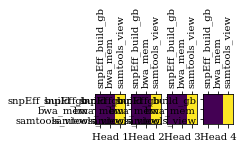

In [15]:
predict_custom_seq()